In [1]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import math

batch_size = 32
num_epochs = 300
random_seed = 42

In the following experiment, we will try to **up-scale images with the following factor:**

In [2]:
scale_factor = 4

## **Preparing the Dataset**

We will build an input pipeline to train our model to up-sample images of *hands*. As mentioned in the book, it is actually difficult to train models for super-resolution, and they usually only shine when they are **trained and applied to specific categories** of images (i.e., images with some common features that the CNN can learn to exploit). Let us imagine that we are, for instance, building a model to improve low-quality from a company specialized in hand-gesture recognition/capture...


### **TensorFlow Datasets - Rock/Paper/Scissors**

In [3]:
import tensorflow_datasets as tfds

hands_builder = tfds.builder('rock_paper_scissors')
hands_builder.download_and_prepare()

print(hands_builder.info)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/rock_paper_scissors/3.0.0.incomplete4GGL9R/rock_paper_scissors-train.tfrecord


  0%|          | 0/2520 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/rock_paper_scissors/3.0.0.incomplete4GGL9R/rock_paper_scissors-test.tfrecord


  0%|          | 0/372 [00:00<?, ? examples/s]

Dataset rock_paper_scissors downloaded and prepared to /root/tensorflow_datasets/rock_paper_scissors/3.0.0. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='rock_paper_scissors',
    version=3.0.0,
    description='Images of hands playing rock, paper, scissor game.',
    homepage='http://laurencemoroney.com/rock-paper-scissors-dataset',
    features=FeaturesDict({
        'image': Image(shape=(300, 300, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=3),
    }),
    total_num_examples=2892,
    splits={
        'test': 372,
        'train': 2520,
    },
    supervised_keys=('image', 'label'),
    citation="""@ONLINE {rps,
    author = "Laurence Moroney",
    title = "Rock, Paper, Scissors Dataset",
    month = "feb",
    year = "2019",
    url = "http://laurencemoroney.com/rock-paper-scissors-dataset"
    }""",
    redistribution_info=,
)



Visualizing some of the images:

In [4]:
import matplotlib.gridspec as gridspec

def plot_image_grid(images, titles=None, figure=None, grayscale=False, transpose=False):
    """
    Plot a grid of n x m images
    :param images:       Images in a n x m array
    :param titles:       (opt.) List of m titles for each image column
    :param figure:       (opt.) Pyplot figure (if None, will be created)
    :param grayscale:    (opt.) Flag to draw the images in grayscale
    :param transpose:    (opt.) Flag to transpose the grid
    :return:             Pyplot figure filled with the images
    """
    num_cols, num_rows = len(images), len(images[0])
    img_ratio = images[0][0].shape[1] / images[0][0].shape[0]

    if transpose:
        vert_grid_shape, hori_grid_shape = (1, num_rows), (num_cols, 1)
        figsize = (int(num_rows * 5 * img_ratio), num_cols * 5)
        wspace, hspace = 0.2, 0.
    else:
        vert_grid_shape, hori_grid_shape = (num_rows, 1), (1, num_cols)
        figsize = (int(num_cols * 5 * img_ratio), num_rows * 5)
        hspace, wspace = 0.2, 0.

    if figure is None:
        figure = plt.figure(figsize=figsize)
    imshow_params = {'cmap': plt.get_cmap('gray')} if grayscale else {}
    grid_spec = gridspec.GridSpec(*hori_grid_shape, wspace=0, hspace=0)

    for j in range(num_cols):
        grid_spec_j = gridspec.GridSpecFromSubplotSpec(
            *vert_grid_shape, subplot_spec=grid_spec[j], wspace=wspace, hspace=hspace)

        for i in range(num_rows):
            ax_img = figure.add_subplot(grid_spec_j[i])
            # ax_img.axis('off')
            ax_img.set_yticks([])
            ax_img.set_xticks([])
            if titles is not None:
                if transpose:
                    ax_img.set_ylabel(titles[j], fontsize=25)
                else:
                    ax_img.set_title(titles[j], fontsize=15)
            ax_img.imshow(images[j][i], **imshow_params)

    figure.tight_layout()
    return figure

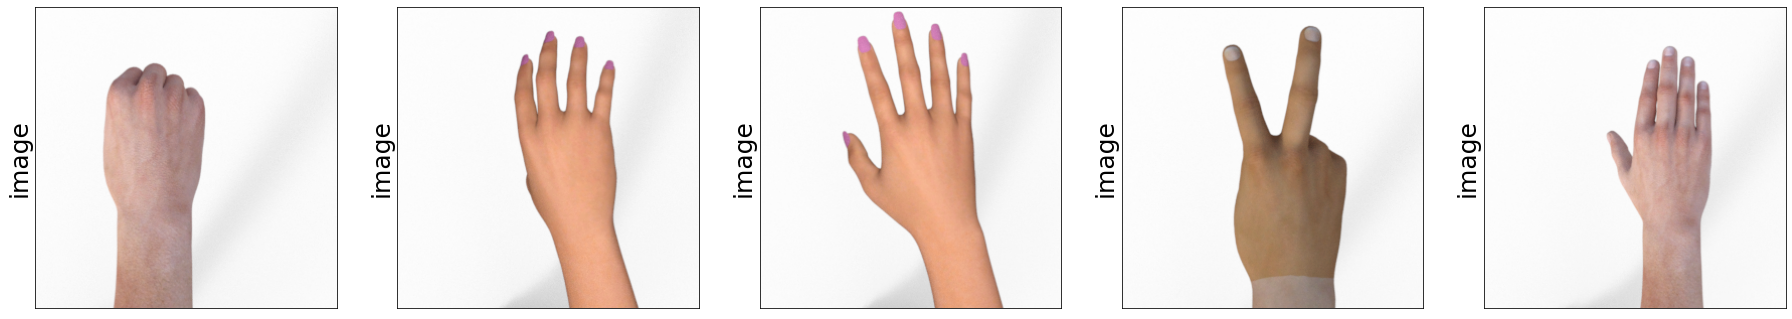

In [5]:
num_show = 5

hands_val_dataset = hands_builder.as_dataset(split=tfds.Split.TEST).batch(num_show)
hands_val_dataset_iter = hands_val_dataset.skip(1).__iter__()
# `.skip(1)` is called to skip the 1st batch, which is a bit "bland" in this dataset
# We will use the 2nd batch for our illustrations, as it has more diverse hands
batch = next(hands_val_dataset_iter)

fig = plot_image_grid([batch['image'].numpy()], titles=['image'], transpose=True)
fig.show()

### **Input pipeline with tf.data**

We have our images ready, but we still need to adapt the input pipelines to our use-cases. We will use `tf.data` to serve training/validation batches to our model. The pipeline below does the following:

* It instantiate a `tf.data.Dataset` of our use-case images through `tensorflow-datasets`
* It randomly augments the training images (random changes of brightness/saturation, random cropping/scaling, etc.)
* It duplicates the images and downscales one in each pair (**the downscaled images will be our model's inputs, the original ones the target**)
* It batches the images together (if `batch_size` > 1) and repeat the process for `num_epochs`

In [6]:
import functools

def _prepare_data_fn(features, scale_factor=4, augment=True,
                    return_batch_as_tuple=True, seed=None):
    """
    Resize image to expected dimension, and opt. apply some random transformations
    :param features: Data
    :param scale_factor: Scale factor for the task
    :param augment: Flag to augment the images with random operations
    :param return_batch_as_tuple: Flag to return the batch data as tuple instead of dict
    :param seed: Seed for random operation
    :return: Processed data
    """
    
    # TF-Dataset returns batches as feature dictionaries, expected by Estimators.
    # To train Keras models, it is more straightforward to return the batch content as tuples
    
    image = features['image']
    # Convert the images to float type, also scaling their values from [0, 255] to [0., 1.]:
    image = tf.image.convert_image_dtype(image, tf.float32)
    
    # Computing the scaled-down shape:
    original_shape = tf.shape(image)
    original_size = original_shape[-3:-1]
    scaled_size = original_size // scale_factor
    # Just in case the original dimenstions were not a multiple of `scale_factor`,
    # we slightly resize the original image so its dimensions now are
    # (to make the loss/metrics computations easier during training):
    original_size_mult = scaled_size * scale_factor
    
    # Opt. augmenting the image
    if augment:
        original_shape_mult = (original_size_mult, [tf.shape(image)[-1]])
        if len(image.shape) > 3:  # batched data
            original_shape_mult = ([tf.shape(image)[0]], *original_shape_mult)
        original_shape_mult = tf.concat(original_shape_mult, axis=0)
        
        # Randomly applied horizontal flip:
        image = tf.image.random_flip_left_right(image)
        
        # Random B/S changes:
        image = tf.image.random_brightness(image, max_delta=0.1, seed=seed)
        image = tf.image.random_saturation(image, lower=0.5, upper=1.5, seed=seed)
        image = tf.clip_by_value(image, 0.0, 1.0)  # keeping pixel values in check
        
        # Random resize and random crop back to expected size
        random_scale_factor = tf.random.uniform([1], minval=1.0, maxval=1.2,
                                                dtype=tf.float32, seed=seed)
        scaled_height = tf.cast(tf.multiply(tf.cast(original_size[0], tf.float32),
                                            random_scale_factor), tf.int32)                    
        scaled_width = tf.cast(tf.multiply(tf.cast(original_size[1], tf.float32),
                                          random_scale_factor), tf.int32)
        scaled_shape = tf.squeeze(tf.stack([scaled_height, scaled_width]))
        image = tf.image.resize(image, scaled_shape)
        image = tf.image.random_crop(image, original_shape, seed=seed)
        
    # Generating the data pair for super-resolution task,
    # i.e. the downscaled image + its original version
    image_downscaled = tf.image.resize(image, scaled_size)
        
    # Just in case the original dimensions were not a multiple of `scale_factor`,
    # we slightly resize the original image so its dimensions now are
    # (to make the loss/metrics computations easier during training):
    original_size_mult = scaled_size * scale_factor
    image = tf.image.resize(image, original_size_mult)
        
    features = (image_downscaled, image) if return_batch_as_tuple else {'image': image_downscaled,
                                                                        'label': image}
    
    return features


def get_hands_dataset_for_superres(phase='train', scale_factor=4, batch_size=32,
                                   num_epochs=None, shuffle=True, augment=False,
                                   return_batch_as_tuple=True, seed=None):
    """
    Instantiate a CIFAR-100 dataset
    :param phase: Phase ('train' or 'val')
    :param scale_factor: Scale factor for the task
    :param batch_size: Batch size
    :param num_epochs: Number of epochs (to repeat the iteration - infinite if None)
    :param shuffle: Flag to shuffle the dataset (if True)
    :param augment: Flag to augment the images with random operations
    :param return_batch_as_tuple: Flag to return the batch data as tuple instead of dict
    :param seed: Seed for random operation
    """
    
    assert (phase == 'train' or phase == 'test')
    
    prepare_data_fn = functools.partial(_prepare_data_fn, scale_factor=scale_factor,
                                       augment=augment, 
                                       return_batch_as_tuple=return_batch_as_tuple, seed=seed)
    
    superres_dataset = hands_builder.as_dataset(split=tfds.Split.TRAIN if phase == 'train'
                                               else tfds.Split.TEST)
    superres_dataset = superres_dataset.repeat(num_epochs)
    
    if shuffle:
        superres_dataset = superres_dataset.shuffle(
            hands_builder.info.splits[phase].num_examples, seed=seed)
        
    superres_dataset = superres_dataset.batch(batch_size)
    superres_dataset = superres_dataset.map(prepare_data_fn, num_parallel_calls=4)
    superres_dataset = superres_dataset.prefetch(1)
    
    return superres_dataset

We now initialize our training and validation input pipelines accordingly:

In [7]:
# Number of images
num_train_imgs = hands_builder.info.splits['train'].num_examples
num_val_imgs = hands_builder.info.splits['test'].num_examples

train_steps_per_epoch = math.ceil(num_train_imgs / batch_size)
val_steps_per_epoch = math.ceil(num_val_imgs / batch_size)

# Input shape:
input_shape = hands_builder.info.features['image'].shape

# Datasets:
train_hands_dataset = get_hands_dataset_for_superres(
    phase='train', scale_factor=scale_factor, batch_size=batch_size,
    num_epochs=num_epochs, augment=True, shuffle=True, seed=random_seed)
val_hands_dataset = get_hands_dataset_for_superres(
    phase='test', scale_factor=scale_factor, batch_size=batch_size,
    num_epochs=1, augment=False, shuffle=False, seed=random_seed)

Let us make sure our pipelines are working as expected, by visualizing a 
batch. For a one-on-one comparison and to better measure the effect of the 
downsampling, we use TensorFlow to re-scale the images back to their
original dimension

PSNR for each pair: [35.33622  30.630665 30.230751 30.764507 33.270763]


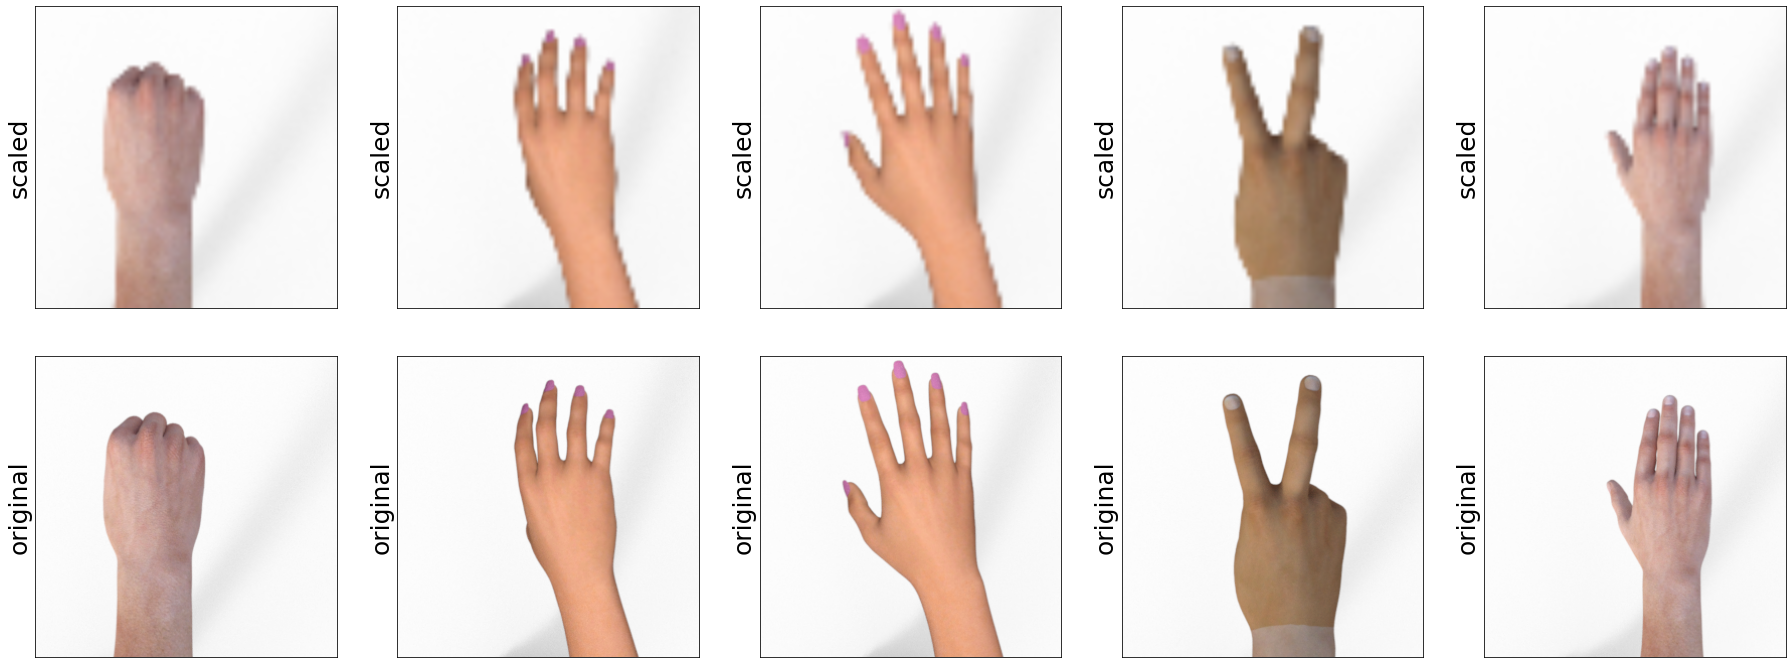

In [8]:
val_hands_dataset_show = val_hands_dataset.take(1)
val_images_input, val_images_target = next(val_hands_dataset_show.__iter__())
val_images_input = val_images_input[num_show:(num_show * 2)]  # skipping 1st "num_show" batch
val_images_target = val_images_target[num_show:(num_show * 2)]

# Resizing the image back with default method to show the artifacts it causes:
val_images_input_resized = tf.image.resize(val_images_input, tf.shape(val_images_target)[1:3])
val_psnr_result = tf.image.psnr(val_images_target, val_images_input_resized, max_val=1.)

# Displaying some examples:
figure = plot_image_grid([val_images_input_resized.numpy(), val_images_target.numpy()],
                        titles=['scaled', 'original'], transpose=True)
figure.show()

print('PSNR for each pair: {}'.format(val_psnr_result.numpy()))

We can clearly see the upscaling artifacts / missing details in the tampered images, as confirmed by
their low PSNR. For later comparision, let us compure the average PSNR for the whole validation dataset:

In [9]:
psnr_val = tf.convert_to_tensor([], dtype=tf.float32)
for v_images_input, v_images_target in val_hands_dataset:
    v_images_input = tf.image.resize(v_images_input, tf.shape(v_images_target)[1:3])
    val_psnr_result = tf.image.psnr(v_images_target, v_images_input, max_val=1.)
    
    psnr_val = tf.concat((psnr_val, val_psnr_result), axis=0)
    
num_images = psnr_val.shape[0]
psnr_val = tf.reduce_mean(psnr_val).numpy()
print('Avg PSNR using default `tf.image.resize_images()` to scale up the' +
     '{} val images: {}'.format(num_images, psnr_val))

Avg PSNR using default `tf.image.resize_images()` to scale up the372 val images: 31.363943099975586


The task of our model will be therefore to recover some of the details in the *corrupted* images (and achieve a better PSNR, i.e., above **~31.4dB**)

## **Building and Training a Deep Auto-Encoder**

In the following section, we will build our first convolutional auto-encoder, which will allow us to efficiently process images, whatever their dimensions


### **Convolutional Auto-Encoder**

In [10]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Lambda, Conv2D, Conv2DTranspose

As already mentioned in the chapter and in this notebook, we will tackle image super resolution with an auto-encoder, similar to how we dealt with image denoising.

Therefore, the idea is to **first use some standard algorithm to scale our downsample input back to its original shape** (e.g., using *bilinear interpolation*), before feeding it to our model. Like in the previous notebook, the task of our model is then to recover the *corrupted* image, i.e., to remove the artifacts caused by the standard upscaling and to recover some details lost with the downsampling (c.f. images above). This way our model can be trained with minimal supervision (c.f. chapter), simply computing a loss between its outputs and the original images. Once trained, our model could be used along this standard upscaling algorithm, to improve the result quality

Concretely, we thus add to our model a first layer which upscales the downsampled input back to their original shape (using bilinear interpolation implemented by `tf.image.resize_images()`):

In [11]:
Upscale = lambda name: Lambda(lambda images: tf.image.resize(images, tf.shape(images)[-3:-1] * scale_factor), name=name)

Then we build the **encoder** and **decoder** parts of our model, **using standard and transposed convolutions**

In [12]:
def simple_dae(inputs, kernel_size=3, filters_orig=16, layer_depth=4):
    """
    Build a simple fully-convolutional DAE network
    :param inputs: Input tensor/placeholder
    :param kernel_size: Kernel size for the convolutions
    :param filters_orig: Number of filters for the 1st CNN layer (then
                             multiplied by 2 each layer)
    :param layer_depth: Number of layers composing the encoder/decoder
    :return: DAE network (Keras Functional API)
    """
    
    # Encoding layers:
    filters = filters_orig
    x = inputs
    for i in range(layer_depth):
        x = Conv2D(filters=filters, kernel_size=kernel_size, activation='relu',
                  strides=2, padding='same', name='enc_conv{}'.format(i))(x)
        filters = min(filters * 2, 512)
        
    # Decoding layers:
    for i in range(layer_depth):
        filters = max(filters // 2, filters_orig)
        x = Conv2DTranspose(filters=filters, kernel_size=kernel_size, activation='relu',
                           strides=2, padding='same', name='dec_deconv{}'.format(i))(x)
    
    decoded = Conv2D(filters=inputs.shape[-1], kernel_size=1, activation='sigmoid',
                    padding='same', name='dec_output')(x)
    
    # Note: we use a sigmoid for the last activation, as we want the output values
    # between 0 and 1, like the input ones
    
    return decoded
    

To have a look how it would process a given image, let us instantiate our network for a fixed input size, and print its summary:

In [13]:
inputs_fixed = Input(shape=(91, 91, 3), name='input')

outputs = simple_dae(inputs_fixed, kernel_size=4, filters_orig=32, layer_depth=4)

autoencoder_example = Model(inputs_fixed, outputs)
autoencoder_example.summary(positions=[.35, .65, .75, 1.])  # `positions` adapts the printed cols' width

del autoencoder_example

Model: "model"
_________________________________________________________________
 Layer (type)         Output Shape        Para  
                                          m #   
 input (InputLayer)   [(None, 91, 91, 3)  0     
                      ]                         
                                                                 
 enc_conv0 (Conv2D)   (None, 46, 46, 32)  1568  
                                                                 
 enc_conv1 (Conv2D)   (None, 23, 23, 64)  3283  
                                          2     
                                                                 
 enc_conv2 (Conv2D)   (None, 12, 12, 128  1312  
                      )                   00    
                                                                 
 enc_conv3 (Conv2D)   (None, 6, 6, 256)   5245  
                                          44    
                                                                 
 dec_deconv0 (Conv2DT  (None, 12, 12, 256  1048  


As we can see, our network indeed follows the encoder-decoder paradigm. The encoder extracts features, reducing the spatial dimensionality of the image layer after layer. Reciprocally, the decoder attempts to recover the original dimension and content.

However, we can also observe that, when the dimensions of our images are not normalized/not even, it is possible that, after downsampling and upsampling through the encoder/decoder, we do **not obtain the exact original size**. To avoid the problems this may cause (when computing the loss comparing outputs and targets), we define a layer to slightly resize the generated image to the target dimensions

In [14]:
ResizeToSame = lambda name: Lambda(lambda images: tf.image.resize(images[0], tf.shape(images[1])[-3:-1]), name=name)
# `images` is a tuple of 2 tensors. We resize the first image tensor to the shape of the 2nd

Combining everything together, we build our network for image super-resolution

In [15]:
def simple_dae_for_super_resolution(inputs, kernel_size=3, filters_orig=16, layer_depth=4):
    """
    Build a simple fully-convolutional DAE network
    :param inputs: Input tensor/placeholder
    :param kernel_size: Kernel size for the convolutions
    :param filters_orig: Number of filters for the 1st CNN layer (them multiplied by 2 each layer)
    :param layer_depth: Number of layers composing the encoder/decoder
    :return: DAE network (Keras Functional API)
    """
    
    # To have a symmetric auto-encoder, we up-sample the input images to 
    # their target dimensions, using the default interpolation up-scaling.
    # The task of the auto-encoder will be to remove the artifacts/noise caused
    # by this default operation
    resized_inputs = Upscale(name='upscale_input')(inputs)
    
    decoded = simple_dae(resized_inputs, kernel_size, filters_orig, layer_depth)
    
    # We take care of the aforementioned edge-case:
    decoded = ResizeToSame(name='dec_output_scale')([decoded, resized_inputs])
    
    return decoded

We can now instantiate our model

In [16]:
# Network hyper-parameters
kernel_size = 4
filters_orig = 32
layer_depth = 4

In [17]:
# Image size will vary. Therefore, we use `None` for the variable dimensions:
inputs = Input(shape=(None, None, input_shape[-1]), name='input')

decoded = simple_dae_for_super_resolution(inputs, kernel_size, filters_orig, layer_depth)

# Auto-encoder model:
autoencoder = Model(inputs, decoded)
autoencoder.summary(positions=[.35, .65, .75, 1.])  # `position` adapts the printed cols' width

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                     Output Shape                 Param #   Connected to             
 input (InputLayer)               [(None, None, None, 3)]      0         []                       
                                                                                                  
 upscale_input (Lambda)           (None, None, None, 3)        0         ['input[0][0]']          
                                                                                                  
 enc_conv0 (Conv2D)               (None, None, None, 32)       1568      ['upscale_input[0][0]']  
                                                                                                  
 enc_conv1 (Conv2D)               (None, None, None, 64)       32832     ['enc_conv0[0][0]']      
                                                                                            

Since our model is **fully-convolutional** and not so deep, its number of trainable parameters is rather low, which will simplify the training



### **Training**
Reusing the **custom metrics and callbacks** defined in the previous notebooks, we train our model

In [18]:
class SimpleLogCallback(tf.keras.callbacks.Callback):
    """ Keras callback for simple, denser console logs."""

    def __init__(self, metrics_dict, num_epochs='?', log_frequency=1,
                 metric_string_template='\033[1m[[name]]\033[0m = \033[94m{[[value]]:5.3f}\033[0m'):
        """
        Initialize the Callback.
        :param metrics_dict:            Dictionary containing mappings for metrics names/keys
                                        e.g. {"accuracy": "acc", "val. accuracy": "val_acc"}
        :param num_epochs:              Number of training epochs
        :param log_frequency:           Log frequency (in epochs)
        :param metric_string_template:  (opt.) String template to print each metric
        """
        super().__init__()

        self.metrics_dict = collections.OrderedDict(metrics_dict)
        self.num_epochs = num_epochs
        self.log_frequency = log_frequency

        # We build a format string to later print the metrics, (e.g. "Epoch 0/9: loss = 1.00; val-loss = 2.00")
        log_string_template = 'Epoch {0:2}/{1}: '
        separator = '; '

        i = 2
        for metric_name in self.metrics_dict:
            templ = metric_string_template.replace('[[name]]', metric_name).replace('[[value]]', str(i))
            log_string_template += templ + separator
            i += 1

        # We remove the "; " after the last element:
        log_string_template = log_string_template[:-len(separator)]
        self.log_string_template = log_string_template

    def on_train_begin(self, logs=None):
        print("Training: \033[92mstart\033[0m.")

    def on_train_end(self, logs=None):
        print("Training: \033[91mend\033[0m.")

    def on_epoch_end(self, epoch, logs={}):
        if (epoch - 1) % self.log_frequency == 0 or epoch == self.num_epochs:
            values = [logs[self.metrics_dict[metric_name]] for metric_name in self.metrics_dict]
            print(self.log_string_template.format(epoch, self.num_epochs, *values))

In [19]:
import collections

optimizer = tf.keras.optimizers.Adam()

psnr_metric = functools.partial(tf.image.psnr, max_val=1.)
psnr_metric.__name__ = 'psnr'

metrics_to_print = collections.OrderedDict([("loss", "loss"), ("v-loss", "val_loss"),
                                           ("psnr", "psnr"), ("v-psnr", "val_psnr")])

callbacks = [tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss',
                                             restore_best_weights=True),
            SimpleLogCallback(metrics_to_print, num_epochs=num_epochs, log_frequency=1)]

In [20]:
optimizer = tf.optimizers.Adam(learning_rate=1e-4)
autoencoder.compile(optimizer=optimizer, loss='mae', metrics=[psnr_metric])

history_ae = autoencoder.fit(train_hands_dataset, epochs=num_epochs, steps_per_epoch=train_steps_per_epoch,
                            validation_data=val_hands_dataset, validation_steps=val_steps_per_epoch, verbose=0,
                            callbacks=callbacks)

Training: start.
Epoch  0/300: loss = 0.248; v-loss = 0.115; psnr = 10.467; v-psnr = 15.521
Epoch  1/300: loss = 0.115; v-loss = 0.066; psnr = 15.864; v-psnr = 19.706
Epoch  2/300: loss = 0.091; v-loss = 0.053; psnr = 17.365; v-psnr = 20.395
Epoch  3/300: loss = 0.093; v-loss = 0.052; psnr = 17.438; v-psnr = 20.593
Epoch  4/300: loss = 0.079; v-loss = 0.059; psnr = 18.474; v-psnr = 19.867
Epoch  5/300: loss = 0.062; v-loss = 0.052; psnr = 20.411; v-psnr = 21.200
Epoch  6/300: loss = 0.061; v-loss = 0.048; psnr = 20.721; v-psnr = 21.383
Epoch  7/300: loss = 0.054; v-loss = 0.048; psnr = 21.291; v-psnr = 21.610
Epoch  8/300: loss = 0.049; v-loss = 0.041; psnr = 22.243; v-psnr = 22.756
Epoch  9/300: loss = 0.047; v-loss = 0.039; psnr = 22.439; v-psnr = 22.978
Epoch 10/300: loss = 0.045; v-loss = 0.056; psnr = 22.682; v-psnr = 21.276
Epoch 11/300: loss = 0.049; v-loss = 0.037; psnr = 22.454; v-psnr = 23.729
Epoch 12/300: loss = 0.046; v-loss = 0.052; psnr = 23.120; v-psnr = 21.323
Epoch 13

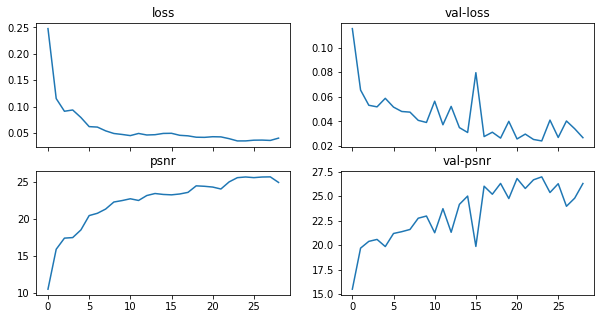

In [21]:
fig, axs = plt.subplots(2, 2, figsize=(10, 5), sharex='col')
axs[0, 0].set_title('loss')
axs[0, 1].set_title('val-loss')
axs[1, 0].set_title('psnr')
axs[1, 1].set_title('val-psnr')

axs[0, 0].plot(history_ae.history['loss'])
axs[0, 1].plot(history_ae.history['val_loss'])
axs[1, 0].plot(history_ae.history['psnr'])
axs[1, 1].plot(history_ae.history['val_psnr'])

As expected, our model converged rather fast, but its performance is quite disappointing. With a PSNR of **~27.3dB** at best on the validation images, we are far below the PSNR of **~31.4dB** when purely using bilinear interpolation to upscale them. Even the metric on the training images stayed below. In terms of PSNR, our model makes things worse

**Note:** PSNR is not an absolute measure of image quality, only evaluating how bad the noise is. Images with the same PSNR may have different ***perceptual quality*** to human eyes (e.g., an image may have some heavy noise, but only in regions which do not contain *salient* details and therefore not really affecting the perceived quality). Evaluating the perceptual quality of images is still open problem

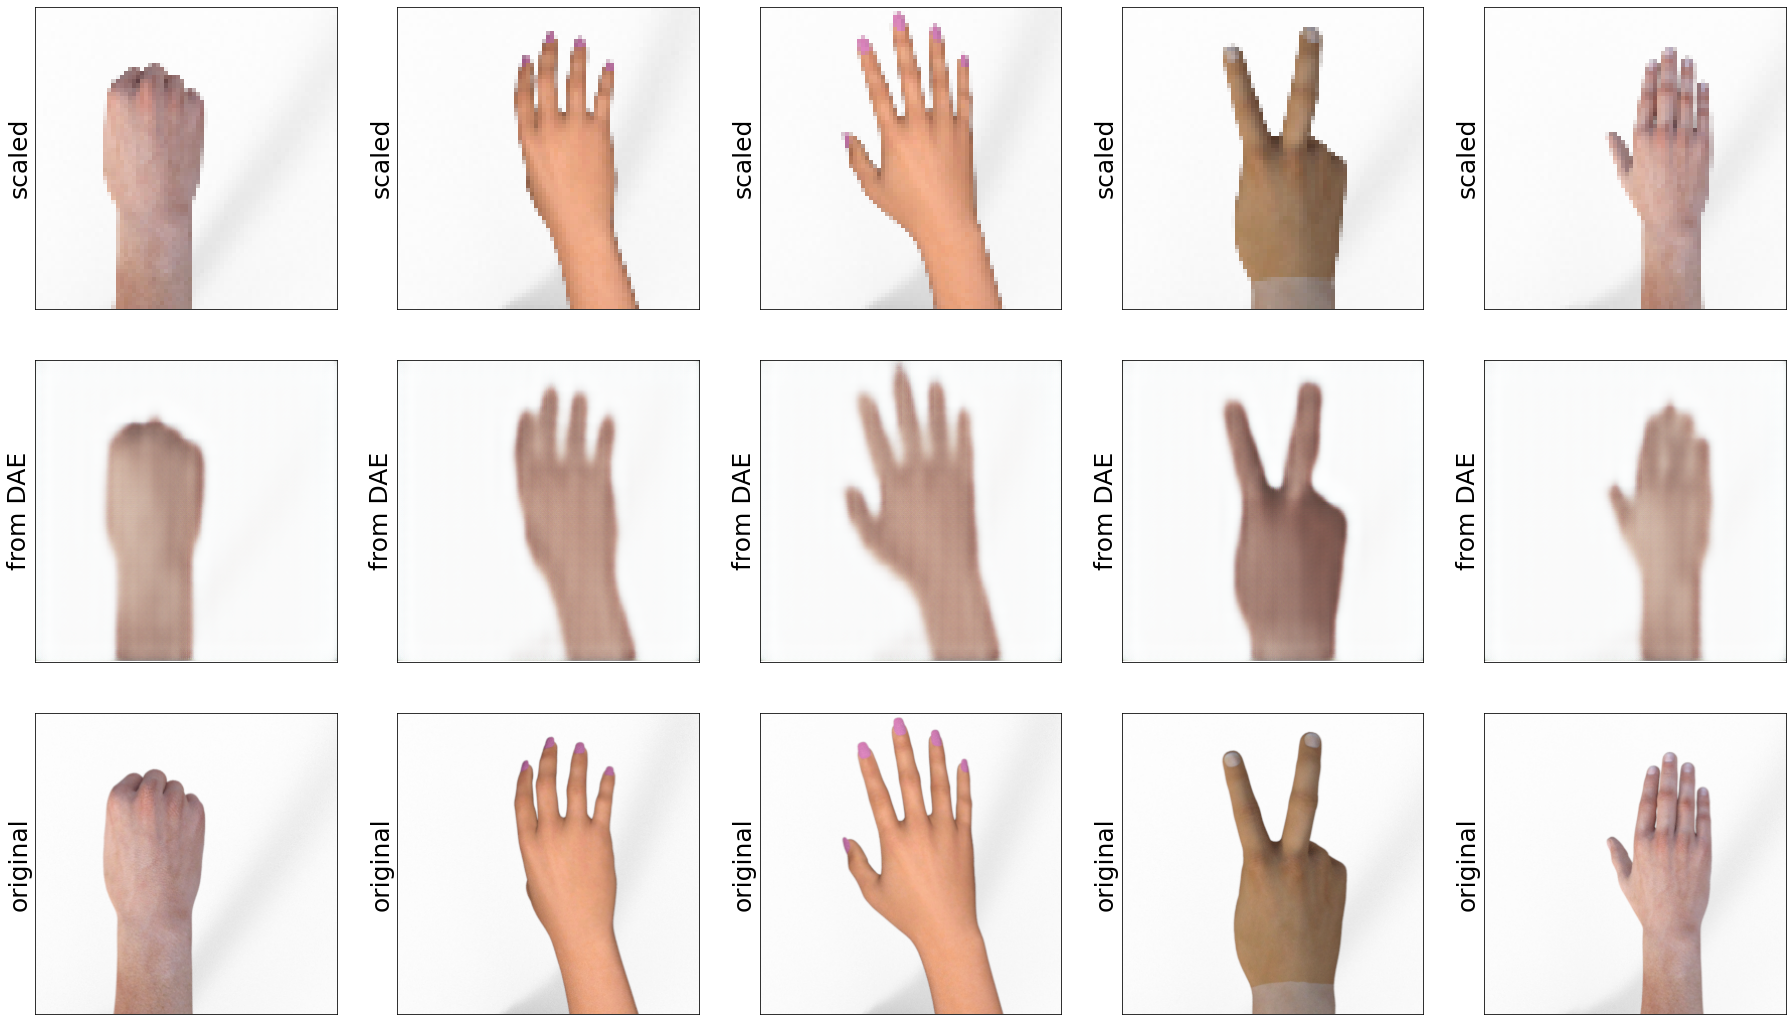

In [22]:
val_images_pred = autoencoder.predict(val_images_input)

figure = plot_image_grid([val_images_input.numpy(), val_images_pred,
                         val_images_target.numpy()], titles=['scaled', 'from DAE', 'original'],
                        transpose=True)

figure.show()

As we can see, the network did its best to soften the sampling artifacts, but images are instead left blurry. We can also notice that colors are sometimes altered. All in all, our images do not look better indeed

## **Building and Training a U-Net**

We will try to do better. We presented some more advanced encoder-decoder architecture. It is time to re-implement and apply one of them. In the following section, we will therefore build our own ***U-Net*** and apply it to image super-resolution

### **U-Net architecture**

Most of the problems with our previous model can be attributed to the **network's bottleneck.** Because of its architecture, our model has to find ways to compress the information, and the decoder only receives this lower-dimensional input to condition its reconstruction. If an image contains unusual features (e.g., unusual objects or colors), the encoder will not properly compress them, and the decoder won't have any other inputs to recover these approximations

*U-Net* has a straightforward solution to this problem: it adds a **skip/shortcut** connection between pairs of encoding/decoding blocks. Therefore, each decoding block is not only conditioned by the rich-yet-low-dimensional features coming from the previous block, but also by the less-coarse map from the parallel encoding block. In other words, the decoding blocks are **provided with both the contextual information** from the preceding block, **and with the location information** from the encoding path

As a quick reminder from the chapter, this is U-Net architecture:

![U-Net architecture](https://github.com/PacktPublishing/Hands-On-Computer-Vision-with-TensorFlow-2/raw/e0d91c1aeadd7558de920583094c05f840b700a9/Chapter06/notebook_images/unet.png)

**Note: batch normalization** and **dropout** layers are not represented here. Typically, each convolutional layer (`conv` in the figure) actually does the following here: `convolution`, (opt.) `batch normalization`, `activation`. Furthermore, the ***Leaky ReLU*** function is commonly used as activation, instead of the standard *ReLU*

To reimplement this architecture, let us go bottom-up. We will start by writting a function wrapping the operations actually done by `conv`, then another wrapping each block of two `conv` together

In [23]:
from tensorflow.keras.layers import (Dropout, MaxPooling2D, LeakyReLU,
                                    concatenate, BatchNormalization)

def name_layer_factory(num=0, name_prefix="", name_suffix=""):
    """
    Help function to name all our layers
    """
    
    def name_layer_fn(layer):
        return '{}{}{}-{}'.format(name_prefix, layer, name_suffix, num)
    
    return name_layer_fn


def conv_bn_lrelu(filters, kernel_size=3, batch_norm=True,
                 kernel_initializer='he_normal', padding='same',
                 name_fn=lambda layer: "conv_bn_lrelu-{}".formar(layer)):
    """
    Return a function behaving like a sequence convolution + BN + LeakyReLU
    :param filters: Number of filters for the convolution
    :param kernel_size: Kernel size for the convolutions
    :param batch_norm: Flag to perform batch normalization
    :param kernel_initializer: Name of kernel initialization method
    :param padding: Name of padding option
    :param name_fn: Function to name each layer of this sequence
    :return: Function chaining layers
    """
    
    def block(x):
        x = Conv2D(filters, kernel_size=kernel_size, activation=None,
                  kernel_initializer=kernel_initializer, padding=padding,
                  name=name_fn('conv'))(x)
        
        if batch_norm:
            x = BatchNormalization(name=name_fn('bn'))(x)
        x = LeakyReLU(alpha=0.3, name=name_fn('act'))(x)
        
        return x
    
    return block


def unet_conv_block(filters, kernel_size=3, batch_norm=True, dropout=False,
                   name_prefix='enc_', name_suffix=0):
    """
    Return a function behaving like a U-Net convolution block
    :param filters: Number of filters for the convolution
    :param kernel_size: Kernel size for the convolutions
    :param batch_norm: Flag to perform batch normalization
    :param dropout: NFlag to perform dropout between the two convs
    :param name_prefix: Prefix for the layer names
    :param name_suffix: FSuffix for the layer names
    :return: Function chaining layers
    """
    
    def block(x):
        # First convolution
        name_fn = name_layer_factory(1, name_prefix, name_suffix)
        x = conv_bn_lrelu(filters, kernel_size=kernel_size, batch_norm=batch_norm,
                         name_fn=name_layer_factory(1, name_prefix, name_suffix))(x)
        if dropout:
            x = Dropout(0.2, name=name_fn('drop'))(x)
            
        # Second convolution
        name_fn = name_layer_factory(2, name_prefix, name_suffix)
        x = conv_bn_lrelu(filters, kernel_size=kernel_size, batch_norm=batch_norm,
                         name_fn=name_layer_factory(2, name_prefix, name_suffix))(x)
        
        return x
    
    return block

Now we can chain everything together, according to the architecture presented above

In [24]:
# As the dimensions of our images are not normalized, and often not even, it is
# possible that after downsampling and upsampling, we do not reobtain the original size
# (with a difference of +/- 1px).
# To avoid the problems this may cause, we define a layer to slightly resize the 
# generated image to the dimensions of the target one

# `image` is a tuple of 2 tensors
# We resize the first image tensor to the shape of the 2nd
ResizeToSame = lambda name: Lambda(lambda images: tf.image.resize(images[0], tf.shape(images[1])[-3:-1]),
                                  name=name)


def unet(x, layer_depth=4, filters_orig=32, kernel_size=4, batch_norm=True, dropout=True,
        final_activation='sigmoid'):
    """
    Define a U-Net network
    :param x: Input tensor/placeholder
    :param filters_orig: Number of filters for the 1st CNN layer
    :param kernel_size: Kernel size for the convolutions
    :param batch_norm: Flag to perform batch normalization
    :param dropout: Flag to perform dropout
    :param final_activation: Name of activation function for the final layer
    :return: Network (Keras Function API)
    """
    
    num_channels = x.shape[-1]
    
    # Encoding layers
    filters = filters_orig
    outputs_for_skip = []
    for i in range(layer_depth):
        
        # Convolution block
        x_conv = unet_conv_block(filters, kernel_size, dropout=dropout, 
                                batch_norm=batch_norm, name_prefix='enc_',
                                name_suffix=i)(x)
        
        # We save the pointer to the output of this encoding block, to pass it
        # to its parallel decoding block afterward
        outputs_for_skip.append(x_conv)
        
        # Downsampling
        x = MaxPooling2D(2)(x_conv)
        
        filters = min(filters * 2, 512)
        
    # Bottleneck layers
    x = unet_conv_block(filters, kernel_size, dropout=dropout, batch_norm=batch_norm,
                       name_suffix='_btleneck')(x)
    
    # Decoding layers
    for i in range(layer_depth):
        filters = max(filters // 2, filters_orig)
        
        # Upsampling
        name_fn = name_layer_factory(3, 'ups_', i)
        x = Conv2DTranspose(filters, kernel_size=kernel_size, strides=2, activation=None,
                           kernel_initializer='he_normal', padding='same', name=name_fn('convT'))(x)
        if batch_norm:
            x = BatchNormalization(name=name_fn('bn'))(x)
        x = LeakyReLU(alpha=0.3, name=name_fn('act'))(x)
        
        # Concatenation with the output of the corresponding encoding block
        shortcut = outputs_for_skip[-(i + 1)]
        x = ResizeToSame(name='resize_to_same{}'.format(i))([x, shortcut])
        
        x = concatenate([x, shortcut], axis=-1, name='dec_conc{}'.format(i))
        
        # Convolution block
        use_dropout = dropout and (i < (layer_depth - 2))
        x = unet_conv_block(filters, kernel_size, batch_norm=batch_norm, dropout=use_dropout,
                           name_prefix='dec_', name_suffix=i)(x)
        
    # x = Conv2D(filters=filters, kernel_size=kernel_size, activation='relu', 
    # padding='same', name='dec_out1')(x)
    # x = Conv2D(filters=filters, kernel_size=kernel_size, activation='relu',
    # padding='same', name='dec_out2')(x)
    x = Conv2D(filters=num_channels, kernel_size=1, activation=final_activation, padding='same',
              name='dec_output')(x)
    
    return x

This is it, we reimplement *U-Net*! As we did with our basic DAE, we instantiate a dummy version with its input size fixed, just for the sake of visualizing how the tensor dimensions evolve through the network

In [25]:
# Network hyper-parameters
kernel_size = 4
filters_orig = 32
layer_depth = 4
use_batch_norm = batch_size > 1

In [26]:
inputs_fixed = Input(shape=(91, 91, 3), name='input')

outputs = unet(inputs_fixed, layer_depth, filters_orig, kernel_size, 
              use_batch_norm, dropout=False)  # no dropout to shorten summary here

unet_example = Model(inputs_fixed, outputs)
unet_example.summary(positions=[.35, .65, .75, 1.])  # `positions` adapts the printed cols' width

del unet_example

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                     Output Shape                 Param #   Connected to             
 input (InputLayer)               [(None, 91, 91, 3)]          0         []                       
                                                                                                  
 enc_conv0-1 (Conv2D)             (None, 91, 91, 32)           1568      ['input[0][0]']          
                                                                                                  
 enc_bn0-1 (BatchNormalization)   (None, 91, 91, 32)           128       ['enc_conv0-1[0][0]']    
                                                                                                  
 enc_act0-1 (LeakyReLU)           (None, 91, 91, 32)           0         ['enc_bn0-1[0][0]']      
                                                                                            

Going a bit deeper and duplicating the convolution layers in each encoding/decoding block, ourr *U-Net* is heavier than our previous model. Its number a parameters is still decent though. We can also see that while it also has a bottleneck (c.f. its typical U-shaped encoder-decoder architecture), the skip connections allow to circumvent it and pass signals between the encoding and decoding blocks

### **Training**

We finally instantiate and train our new model, using the same script as before

In [27]:
inputs = Input(shape=(None, None, input_shape[-1]), name='input')
resized_inputs = Upscale(name='upscale_input')(inputs)

outputs = unet(resized_inputs, layer_depth, filters_orig, kernel_size, use_batch_norm)

unet_model = Model(inputs, outputs)

In [28]:
# Opt. we reduce the batch size in case the device doesn't have enough memory
batch_size = 16

train_hands_dataset = get_hands_dataset_for_superres(
    phase='train', scale_factor=scale_factor, batch_size=batch_size,
    num_epochs=num_epochs, augment=True, shuffle=True, seed=random_seed)

val_hands_dataset = get_hands_dataset_for_superres(
    phase='test', scale_factor=scale_factor, batch_size=batch_size,
    num_epochs=1, augment=False, shuffle=False, seed=random_seed)

callbacks = [tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True),
            SimpleLogCallback(metrics_to_print, num_epochs=num_epochs, log_frequency=1)]

In [29]:
optimizer = tf.optimizers.Adam(learning_rate=1e-4)
unet_model.compile(optimizer=optimizer, loss='mae', metrics=[psnr_metric])

history_unet = unet_model.fit(train_hands_dataset, epochs=num_epochs,
                             steps_per_epoch=train_steps_per_epoch,
                             validation_data=val_hands_dataset, 
                             validation_steps=val_steps_per_epoch,
                             verbose=0, callbacks=callbacks)

Training: start.
Epoch  0/300: loss = 0.206; v-loss = 0.148; psnr = 12.634; v-psnr = 13.284
Epoch  1/300: loss = 0.152; v-loss = 0.123; psnr = 15.348; v-psnr = 17.096
Epoch  2/300: loss = 0.136; v-loss = 0.100; psnr = 16.152; v-psnr = 18.669
Epoch  3/300: loss = 0.118; v-loss = 0.106; psnr = 17.339; v-psnr = 18.296
Epoch  4/300: loss = 0.108; v-loss = 0.104; psnr = 18.052; v-psnr = 18.449
Epoch  5/300: loss = 0.098; v-loss = 0.086; psnr = 18.852; v-psnr = 20.127
Epoch  6/300: loss = 0.085; v-loss = 0.091; psnr = 20.034; v-psnr = 19.607
Epoch  7/300: loss = 0.080; v-loss = 0.081; psnr = 20.566; v-psnr = 20.565
Epoch  8/300: loss = 0.071; v-loss = 0.070; psnr = 21.564; v-psnr = 21.800
Epoch  9/300: loss = 0.067; v-loss = 0.073; psnr = 22.129; v-psnr = 21.690
Epoch 10/300: loss = 0.061; v-loss = 0.065; psnr = 23.006; v-psnr = 22.654
Epoch 11/300: loss = 0.056; v-loss = 0.060; psnr = 23.601; v-psnr = 23.142
Epoch 12/300: loss = 0.049; v-loss = 0.052; psnr = 24.833; v-psnr = 24.364
Epoch 13

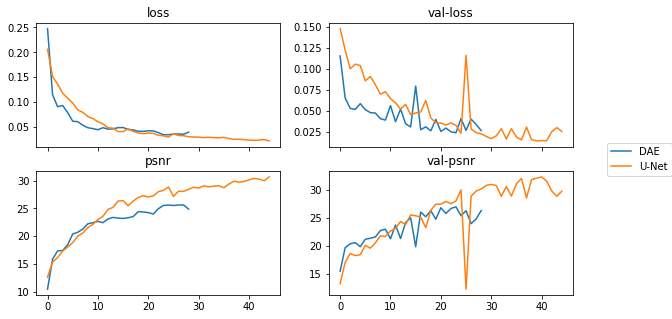

In [31]:
histories = { 'DAE': history_ae, 'U-Net': history_unet }

fig, axs = plt.subplots(2, 2, figsize=(10, 5), sharex='col')
axs[0, 0].set_title('loss')
axs[0, 1].set_title('val-loss')
axs[1, 0].set_title('psnr')
axs[1, 1].set_title('val-psnr')

lines, labels = [], []
for config_name in histories:
    history = histories[config_name]
    axs[0, 0].plot(history.history['loss'])
    axs[0, 1].plot(history.history['val_loss'])
    axs[1, 0].plot(history.history['psnr'])
    line = axs[1, 1].plot(history.history['val_psnr'])
    lines.append(line[0])
    labels.append(config_name)
    
fig.legend(lines, labels, loc='center right', borderaxespad=0.1)
plt.subplots_adjust(right=0.87)

Though our training may have had some hiccups, the metrics look quite better, and it seems our network was able to reduce the sampling noise (c.f. best PSNR values = 31.8db > 31.4dB). Let us visualize here some results:

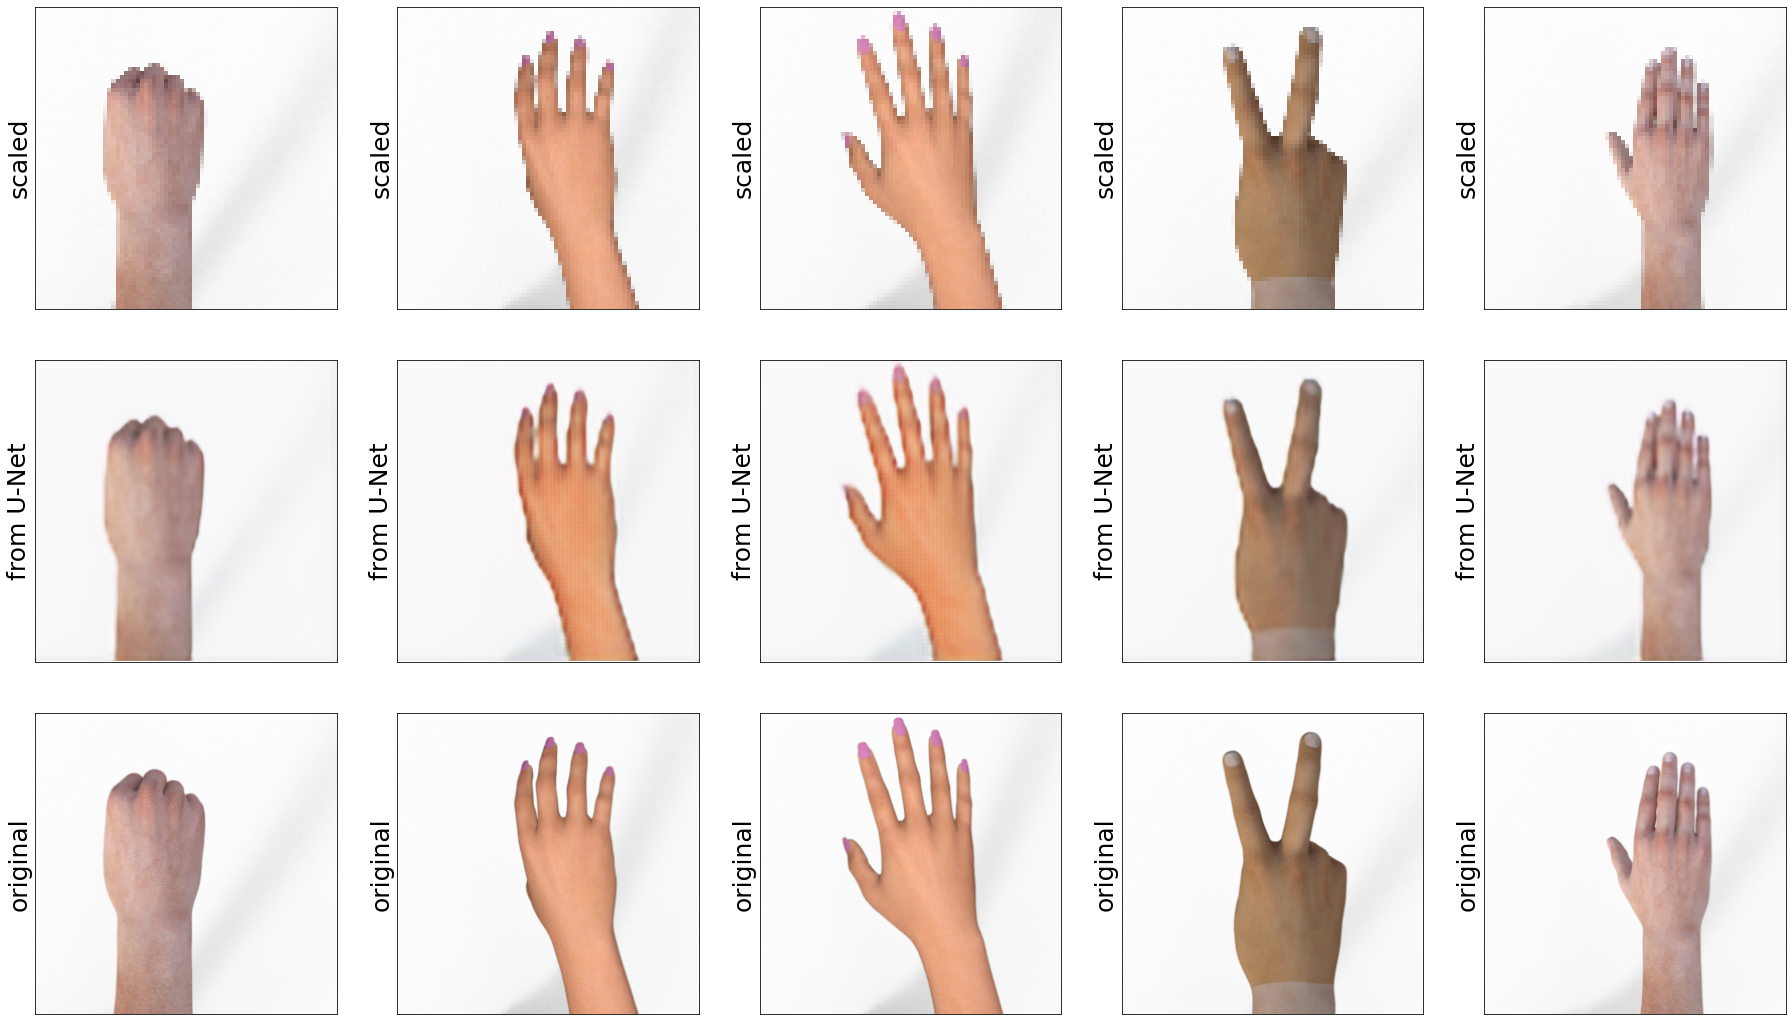

In [32]:
val_images_pred = unet_model.predict(val_images_input)

figure = plot_image_grid([val_images_input.numpy(), val_images_pred,
                         val_images_target.numpy()],
                        titles=['scaled', 'from U-Net', 'original'],
                        transpose=True)
figure.show()